<a href="https://colab.research.google.com/github/samjurassic/datascience-demo/blob/main/intro/pandas-intro-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Python Workshop: Part 2

Welcome! This is part 2 of 2 of our intro to Python and Pandas.

In this notebook we will cover:
- Using APIs and API wrapper libraries to retrieve data
- Additional data visualizations with Seaborn
- Window functions and aggregations with Pandas
- Excel file I/O
- [Regular Expressions](https://docs.python.org/3/howto/regex.html)
- Decision Tree Learning with scikit-learn

We will be focusing on common data manipulation tasks in Pandas, this focuses on solutions without too many low-level details, so be sure to check out the [documentation](https://pandas.pydata.org/docs/index.html) if you want to learn more about the underlying functionality.

For additional visualization ideas, see the Seaborn [Gallery](https://seaborn.pydata.org/examples/index.html)

In [1]:
import os
import re
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from sklearn.tree import DecisionTreeRegressor, plot_tree

### Getting data from an API with requests
We will be using [NYC Air Quality Data](https://data.cityofnewyork.us/Environment/Air-Quality/c3uy-2p5r/about_data) accessed via an API endpoint.

The requests library is used to interact with APIs. API responses are typically in JSON, which is a similar format to a python dict.

The endpoint is an https address, followed by a set of filters after the "?". Here we are filtering to PM 2.5 pollution (indicator ID = 365) during Summer 2022.

In [2]:
# The URL is used to specify the endpoint and query parameters
api_url = "https://data.cityofnewyork.us/resource/c3uy-2p5r.json?indicator_id=365&geo_type_name=Borough"

# a GET request elicits a response from the server, in this case a series of data
result = requests.get(api_url)

In [3]:
type(result)

requests.models.Response

In [4]:
type(result.json())

list

In [5]:
type(result.json()[0])

dict

In [6]:
# let's check out the first result
result.json()[0]

{'unique_id': '179584',
 'indicator_id': '365',
 'name': 'Fine particles (PM 2.5)',
 'measure': 'Mean',
 'measure_info': 'mcg/m3',
 'geo_type_name': 'Borough',
 'geo_join_id': '2',
 'geo_place_name': 'Brooklyn',
 'time_period': 'Summer 2012',
 'start_date': '2012-06-01T00:00:00.000',
 'data_value': '10.4'}

In [7]:
# pd.DataFrame can parse a list of JSON items/dicts
aq = pd.DataFrame.from_records(result.json())
aq.head()

,unique_id,indicator_id,name,measure,measure_info,geo_type_name,geo_join_id,geo_place_name,time_period,start_date,data_value
0,179584,365,Fine particles (PM 2.5),Mean,mcg/m3,Borough,2,Brooklyn,Summer 2012,2012-06-01T00:00:00.000,10.4
1,179589,365,Fine particles (PM 2.5),Mean,mcg/m3,Borough,2,Brooklyn,Summer 2013,2013-06-01T00:00:00.000,10.3
2,410725,365,Fine particles (PM 2.5),Mean,mcg/m3,Borough,2,Brooklyn,Annual Average 2016,2015-12-31T00:00:00.000,7.8
3,179590,365,Fine particles (PM 2.5),Mean,mcg/m3,Borough,3,Manhattan,Summer 2013,2013-06-01T00:00:00.000,11.8
4,742157,365,Fine particles (PM 2.5),Mean,mcg/m3,Borough,4,Queens,Summer 2021,2021-06-01T00:00:00.000,8.1


In [8]:
# what time periods are in this dataset?
aq.time_period.unique()

array(['Summer 2012', 'Summer 2013', 'Annual Average 2016', 'Summer 2021',
       'Annual Average 2021', 'Winter 2020-21', 'Summer 2011',
       'Summer 2010', 'Summer 2016', 'Annual Average 2017',
       'Annual Average 2011', 'Winter 2010-11', 'Summer 2009',
       'Annual Average 2013', 'Annual Average 2009', 'Winter 2018-19',
       'Winter 2021-22', 'Winter 2015-16', 'Annual Average 2012',
       'Summer 2015', 'Summer 2019', 'Winter 2014-15',
       'Annual Average 2015', 'Winter 2012-13', 'Winter 2017-18',
       'Annual Average 2018', 'Annual Average 2010', 'Winter 2019-20',
       'Winter 2009-10', 'Winter 2016-17', 'Winter 2011-12',
       'Summer 2014', 'Annual Average 2020', 'Summer 2017', 'Summer 2018',
       'Annual Average 2014', 'Summer 2022', 'Winter 2013-14',
       'Annual Average 2019', 'Summer 2020', 'Winter 2008-09',
       'Annual Average 2022'], dtype=object)

In [9]:
# drop annual from data so we can look at seasonal trends (we are using the NOT operator "~" instead of df.drop)
aq = aq[~aq.time_period.str.startswith("Annual")]

In [10]:
# confirm we have borough-level data (not zip code or district)
aq.geo_type_name.unique()

array(['Borough'], dtype=object)

In [11]:
# note that all of the API columns read in as text, so we'll need to convert the numbers and datetime
aq.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, 0 to 207
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   unique_id       140 non-null    object
 1   indicator_id    140 non-null    object
 2   name            140 non-null    object
 3   measure         140 non-null    object
 4   measure_info    140 non-null    object
 5   geo_type_name   140 non-null    object
 6   geo_join_id     140 non-null    object
 7   geo_place_name  140 non-null    object
 8   time_period     140 non-null    object
 9   start_date      140 non-null    object
 10  data_value      140 non-null    object
dtypes: object(11)
memory usage: 13.1+ KB


In [12]:
# convert to numeric
aq["data_value"] = pd.to_numeric(aq.data_value)

# convert to datetime
aq["start_date"] = pd.to_datetime(aq.start_date)

<Axes: xlabel='data_value', ylabel='Count'>

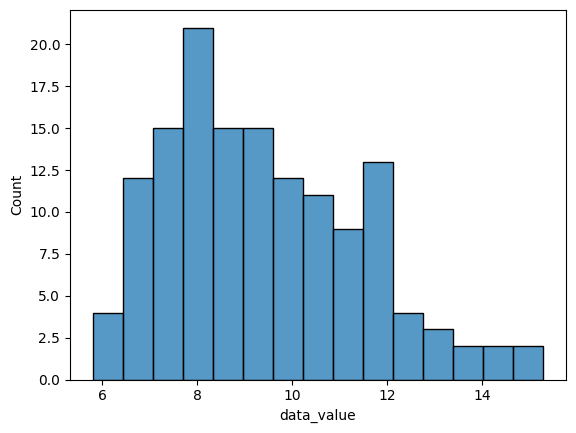

In [13]:
# let's check out the distribution of air quality values in the data set (high is bad)
sns.histplot(aq.data_value, bins=15)

<Axes: xlabel='start_date', ylabel='data_value'>

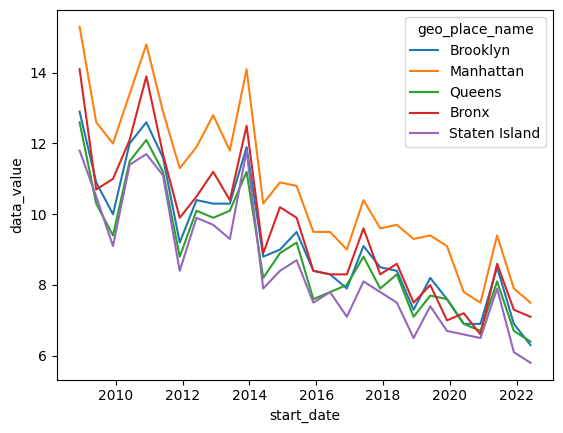

In [14]:
# plotting PM2.5 air pollution over time in each borough
sns.lineplot(data=aq, x="start_date", y="data_value", hue="geo_place_name")

### Using an API wrapper
Many APIs provide a wrapper, i.e. a library containing higher-level functions for easier access to the API. **yfinance** is the library for the Yahoo Finance API, which contains stock prices and other information on public companies.


In [15]:
# specify query parameters
ticker_list = ["AAPL", "MSFT", "NVDA", "SPY"]
start_date = "2024-01-01"
end_date = "2024-04-30"

stocks = yf.download(tickers=ticker_list, start=start_date, end=end_date, interval="1d")

[*********************100%***********************]  4 of 4 completed


In [16]:
# see that we have a multi-indexed dataframe with multiple levels (Price, Ticker)
stocks.head()

Price                       Adj Close                                     \
Ticker                           AAPL        MSFT       NVDA         SPY   
Date                                                                       
2024-01-02 00:00:00+00:00  184.938217  368.854095  48.157665  468.234558   
2024-01-03 00:00:00+00:00  183.553467  368.585571  47.558792  464.410675   
2024-01-04 00:00:00+00:00  181.222336  365.940002  47.987705  462.914764   
2024-01-05 00:00:00+00:00  180.495071  365.751068  49.086464  463.548798   
2024-01-08 00:00:00+00:00  184.858521  372.653351  52.241787  470.166382   

Price                           Close                                     \
Ticker                           AAPL        MSFT       NVDA         SPY   
Date                                                                       
2024-01-02 00:00:00+00:00  185.639999  370.869995  48.167999  472.649994   
2024-01-03 00:00:00+00:00  184.250000  370.600006  47.569000  468.790009   
2024-01-04 00:00:00+00:00  181.910004  367.940002  47.998001  467.279999   
2024-01-05 00:00:00+00:00  181.179993  367.750000  49.097000  467.920013   
2024-01-08 00:00:00+00:00  185.559998  374.690002  52.252998  474.600006   

Price                            High              ...        Low              \
Ticker                           AAPL        MSFT  ...       NVDA         SPY   
Date                                               ...                          
2024-01-02 00:00:00+00:00  188.440002  375.899994  ...  47.595001  470.489990   
2024-01-03 00:00:00+00:00  185.880005  373.260010  ...  47.320000  468.170013   
2024-01-04 00:00:00+00:00  183.089996  373.100006  ...  47.507999  467.049988   
2024-01-05 00:00:00+00:00  182.759995  372.059998  ...  48.306000  466.429993   
2024-01-08 00:00:00+00:00  185.600006  375.200012  ...  49.479000  468.299988   

Price                            Open                                     \
Ticker                           AAPL        MSFT       NVDA         SPY   
Date                                                                       
2024-01-02 00:00:00+00:00  187.149994  373.859985  49.243999  472.160004   
2024-01-03 00:00:00+00:00  184.220001  369.010010  47.485001  470.429993   
2024-01-04 00:00:00+00:00  182.149994  370.670013  47.766998  468.299988   
2024-01-05 00:00:00+00:00  181.990005  368.970001  48.462002  467.489990   
2024-01-08 00:00:00+00:00  182.089996  369.299988  49.512001  468.429993   

Price                        Volume                                  
Ticker                         AAPL      MSFT       NVDA        SPY  
Date                                                                 
2024-01-02 00:00:00+00:00  82488700  25258600  411254000  123623700  
2024-01-03 00:00:00+00:00  58414500  23083500  320896000  103585900  
2024-01-04 00:00:00+00:00  71983600  20901500  306535000   84232200  
2024-01-05 00:00:00+00:00  62303300  20987000  415039000   86060800  
2024-01-08 00:00:00+00:00  59144500  23134000  642510000   74879100  

[5 rows x 24 columns]

In [17]:
# let's select prices from the dataframe and melt to normalize the data
prices = stocks["Adj Close"].reset_index().melt(id_vars="Date")
prices.tail()

,Date,Ticker,value
323,2024-04-23 00:00:00+00:00,SPY,502.482697
324,2024-04-24 00:00:00+00:00,SPY,502.244202
325,2024-04-25 00:00:00+00:00,SPY,500.336243
326,2024-04-26 00:00:00+00:00,SPY,505.076385
327,2024-04-29 00:00:00+00:00,SPY,506.865082


<Axes: xlabel='Date', ylabel='value'>

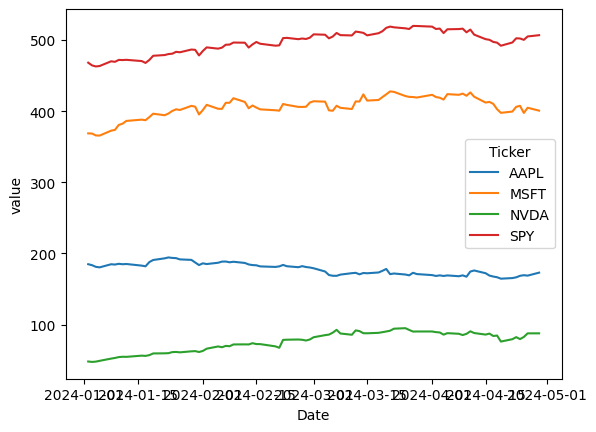

In [18]:
sns.lineplot(data=prices, x="Date", y="value", hue="Ticker" )

### Calculating Window functions

Window functions are functions applied to distinct groups of data, without the final aggregation step of the GroupBy. This means you end up with the same number of rows you started with. An example is ranking or a cumulative sum per group.

In Pandas, you still use GroupBy to do this, and the function you choose determines whether you aggregate the rows in the group or return a windowed value.

In [19]:
# we will calculate the daily percent change in price for each ticker symbol (ensure DF is sorted correctly!)
prices["daily_pct"] = (prices
                       .sort_values(["Ticker", "Date"])
                       .groupby("Ticker")["value"] # just pct change on the value column
                       .pct_change())

In [20]:
# using the daily percent changes, we can calculate the cumulative percent return
prices["pct_return"] = (prices
                        .groupby("Ticker")["daily_pct"]
                        .apply(lambda x: (1 + x).cumprod())
                        .droplevel(0)) # droplevel removes the multi-index so we get a single Series back

In [21]:
# now we have daily and cumulative percent returns for each stock
prices.head(10)

,Date,Ticker,value,daily_pct,pct_return
0,2024-01-02 00:00:00+00:00,AAPL,184.938217,NaN,NaN
1,2024-01-03 00:00:00+00:00,AAPL,183.553467,-0.007488,0.992512
2,2024-01-04 00:00:00+00:00,AAPL,181.222336,-0.012700,0.979907
3,2024-01-05 00:00:00+00:00,AAPL,180.495071,-0.004013,0.975975
4,2024-01-08 00:00:00+00:00,AAPL,184.858521,0.024175,0.999569
5,2024-01-09 00:00:00+00:00,AAPL,184.440109,-0.002263,0.997307
6,2024-01-10 00:00:00+00:00,AAPL,185.486160,0.005671,1.002963
7,2024-01-11 00:00:00+00:00,AAPL,184.888412,-0.003223,0.999731
8,2024-01-12 00:00:00+00:00,AAPL,185.217163,0.001778,1.001508
9,2024-01-16 00:00:00+00:00,AAPL,182.935822,-0.012317,0.989173


### Visualizing categorical and continuous data

With one categorical axis (ticker) and one continuous axis (price/change) we can use box-style and scatter-style plots to visualize the distribution of price changes for each ticker.

To plot the cumulative returns, we'll make a line plot of returns over time.

<Axes: xlabel='daily_pct', ylabel='Ticker'>

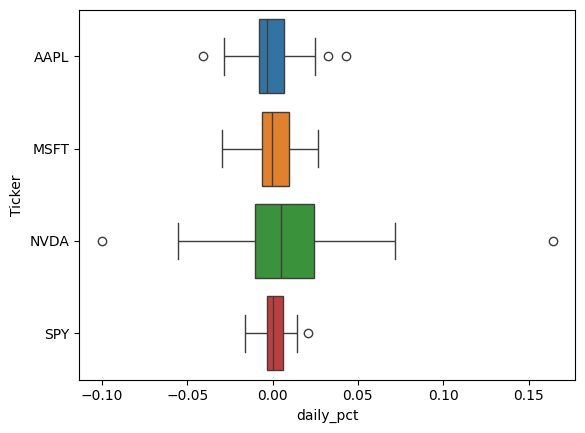

In [22]:
# let's look at the distribution of daily percent changes for each stock
sns.boxplot(data=prices, x="daily_pct", y="Ticker", hue="Ticker")

<Axes: xlabel='Date', ylabel='pct_return'>

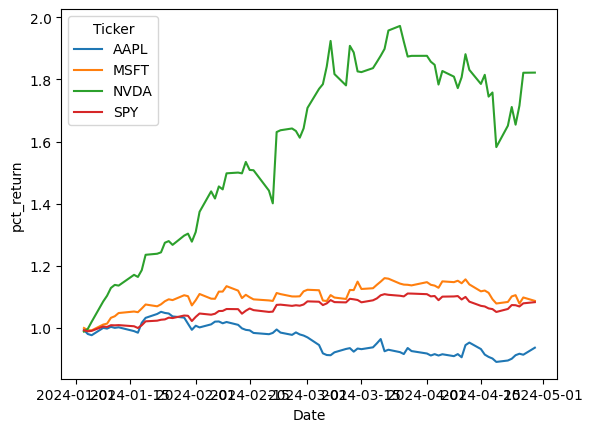

In [23]:
# let's make a plot to compare the percent returns
sns.lineplot(data=prices, x="Date", y="pct_return", hue="Ticker")

### Machine Learning (in 5 mins)

We will briefly show a demonstration of decision tree learning in Python with scikit-learn. We will use a decision tree to approximate a sine function, based on [this](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html#sphx-glr-auto-examples-tree-plot-tree-regression-py) tutorial.

In [24]:
# Create a random dataset
rng = np.random.RandomState(1)
# generate 80 random numbers on [0,1], multiply by 5 and sort
X = np.sort(5 * rng.rand(80, 1), axis=0)
# create target function of sin(X)
y = np.sin(X).ravel() + rng.normal(0, 0.1, 80)
# add some noise to every 5th observation
# y[::5] +=

# Fit regression model, we will compare 2 different depths of tree
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# combine into dataframe
ml_df = pd.DataFrame()
ml_df["x"] = X_test.ravel()
ml_df["y_true"] = np.sin(X_test).ravel()
ml_df["y_1"] = y_1
ml_df["y_2"] = y_2

ml_df_melt = ml_df.melt(id_vars=["x"], var_name="series")

In [25]:
ml_df_melt.head()

,x,series,value
0,0.00,y_true,0.000000
1,0.01,y_true,0.010000
2,0.02,y_true,0.019999
3,0.03,y_true,0.029996
4,0.04,y_true,0.039989


[Text(0.5, 0.8333333333333334, 'x[0] <= 3.133\nsquared_error = 0.486\nsamples = 80\nvalue = 0.175'),
 Text(0.25, 0.5, 'x[0] <= 0.443\nsquared_error = 0.091\nsamples = 51\nvalue = 0.648'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'squared_error = 0.015\nsamples = 8\nvalue = 0.209'),
 Text(0.375, 0.16666666666666666, 'squared_error = 0.063\nsamples = 43\nvalue = 0.729'),
 Text(0.75, 0.5, 'x[0] <= 3.975\nsquared_error = 0.095\nsamples = 29\nvalue = -0.657'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'squared_error = 0.018\nsamples = 15\nvalue = -0.388'),
 Text(0.875, 0.16666666666666666, 'squared_error = 0.017\nsamples = 14\nvalue = -0.945')]

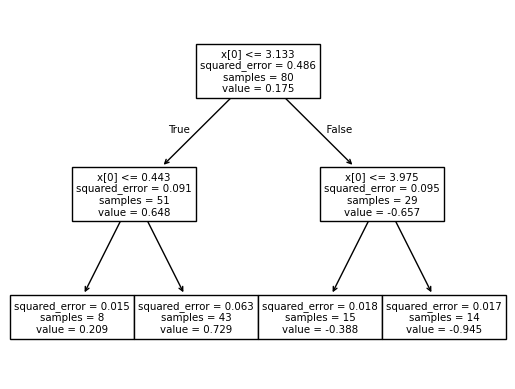

In [26]:
# let's plot the tree and learned rules
plot_tree(regr_1)

<Axes: xlabel='x', ylabel='value'>

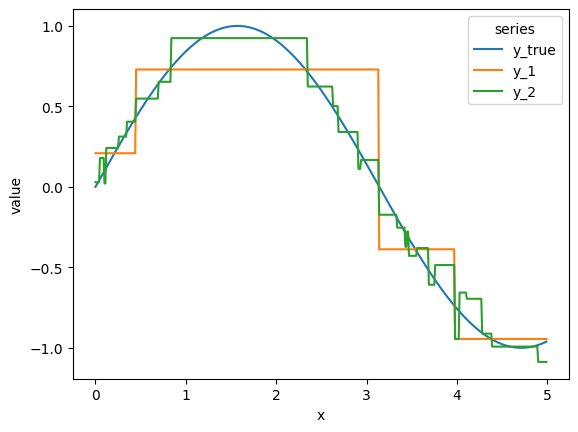

In [27]:
# let's compare the 2 fitted trees to the actual sine function
sns.lineplot(data=ml_df_melt, x="x", y="value", hue="series")